# Import modules


In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os
import time


# import shutil
import random
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, roc_auc_score
from tensorflow.keras.applications import ResNet50V2
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Adjust seaborn plot settings
sns.set(rc={"figure.figsize":(10, 7)})
sns.set_style("whitegrid")

# File paths

In [9]:
path_to_labels = '../Venturas/technical_test_venturas/labelnames.csv'
path_to_training_imges = '../Venturas/technical_test_venturas/dataset/train'
path_to_testing_imges = '../Venturas/technical_test_venturas/dataset/test'
path_to_validation_imges = '../Venturas/technical_test_venturas/dataset/validation'

# Dataframe for Image Directories


In [10]:
# Adidas 
adidas_train_img_1 = [
    path_to_training_imges + '/adidas/' + file for file in os.listdir(path_to_training_imges + '/adidas')
]


adidas_test_img_1 = [
    path_to_testing_imges + '/adidas/' + file for file in os.listdir(path_to_testing_imges + '/adidas')
]

adidas_train_img_list = (adidas_train_img_1 
                       + adidas_test_img_1)

# Nike
nike_train_img_1 = [
    path_to_training_imges + '/nike/' + file for file in os.listdir(path_to_training_imges + '/nike')
]


nike_test_img_1 = [
    path_to_testing_imges + '/nike/' + file for file in os.listdir(path_to_testing_imges + '/nike')
]

nike_train_img_list = (nike_train_img_1 
                       + nike_test_img_1)

adidas_filepath_df = pd.DataFrame({
    'file_paths' : adidas_train_img_list,
    'label' : 'Adidas'
})

nike_filepath_df = pd.DataFrame({
    'file_paths' : nike_train_img_list,
    'label' : 'Nike'
})

img_filepaths_df = pd.concat([adidas_filepath_df, nike_filepath_df], ignore_index=True)

In [11]:
img_filepaths_df.describe()

file_paths   label
count                                                 520     520
unique                                                520       2
top     ../Venturas/technical_test_venturas/dataset/tr...  Adidas
freq                                                    1     260

In [12]:
img_filepaths_df['label'].value_counts()

Adidas    260
Nike      260
Name: label, dtype: int64

# Sample Image Load

Load/Read images


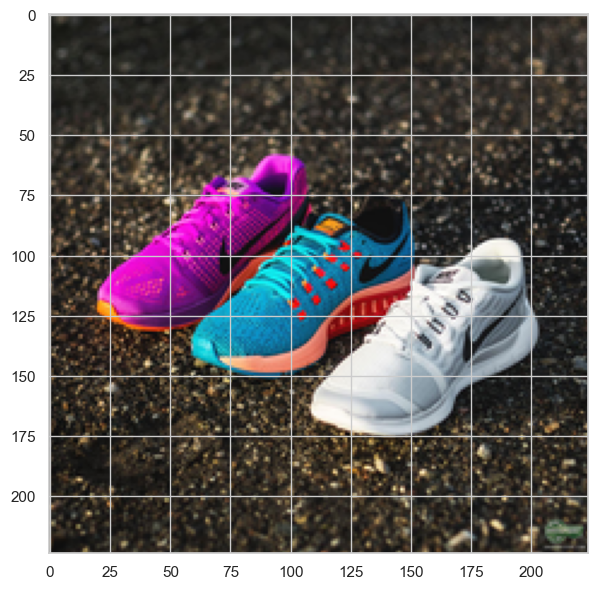

In [25]:
ex_img = mpimg.imread(img_filepaths_df.iloc[519, 0]) # first row, filepath column
plt.imshow(ex_img)
plt.show()

# Determining Image Size

In [26]:
def getImageShape(path_to_images):
    """Reads image from filepath and returns image shape"""
    image = cv2.imread(path_to_images)
    shape = image.shape
    return shape

# Get image shapes 
image_shapes_list = []
for img in img_filepaths_df['file_paths']:
    image_shapes_list.append(getImageShape(img))

print("Image shapes:\n", set(image_shapes_list))

Image shapes:
 {(676, 1200, 3), (683, 683, 3), (300, 250, 3), (546, 970, 3), (1124, 1686, 3), (300, 285, 3), (483, 700, 3), (796, 640, 3), (198, 332, 3), (725, 966, 3), (825, 1625, 3), (230, 332, 3), (224, 224, 3), (218, 332, 3), (1920, 2560, 3), (497, 651, 3)}


# Deep Learning Model

Deep CNN Model

In [27]:
dl_model = Sequential()
dl_model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
dl_model.add(MaxPool2D())

dl_model.add(Conv2D(32, 3, padding="same", activation="relu"))
dl_model.add(MaxPool2D())

dl_model.add(Conv2D(32, 3, padding="same", activation="relu"))
dl_model.add(MaxPool2D())

dl_model.add(Conv2D(64, 3, padding="same", activation="relu"))
dl_model.add(MaxPool2D())

dl_model.add(Conv2D(128, 3, padding="same", activation="relu"))
dl_model.add(MaxPool2D())
dl_model.add(Dropout(0.4))

dl_model.add(Flatten())
dl_model.add(Dense(128,activation="relu"))
dl_model.add(Dense(2, activation="softmax"))

dl_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        1

In [28]:
#dynamic learniing rate
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
#     **kwargs
)
dl_model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])


In [13]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=30,
                             horizontal_flip=True,
                             channel_shift_range=True)

In [14]:
batch_size = 150
val_batch_size = 70

train_generator = datagen.flow_from_directory('../Venturas/technical_test_venturas/dataset/train/', 
                                              target_size=(224, 224),
                                              class_mode='binary', 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=10)

validation_generator = datagen.flow_from_directory('../Venturas/technical_test_venturas/dataset/validation/', 
                                            target_size=(224, 224), 
                                            class_mode='binary', 
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=10)

test_generator= datagen.flow_from_directory('../Venturas/technical_test_venturas/dataset/test/', 
                                            target_size=(224, 224), 
                                            class_mode='binary', 
                                            batch_size=val_batch_size,
                                            shuffle=True,
                                            seed=10)

Found 460 images belonging to 2 classes.
Found 55 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


# View Sample Image transformations

(150, 224, 224, 3)


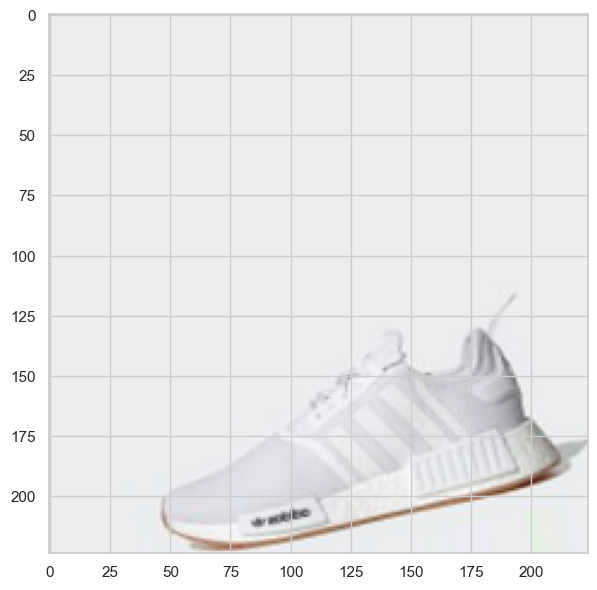

(150, 224, 224, 3)


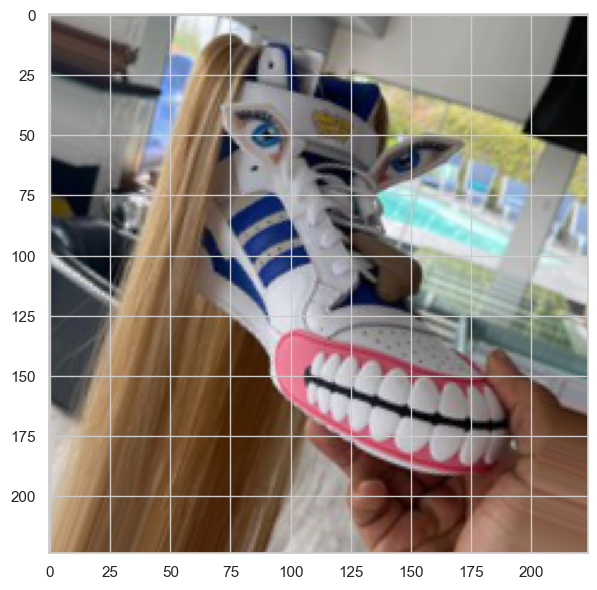

/Users/rahuldebmohalder/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(150, 224, 224, 3)


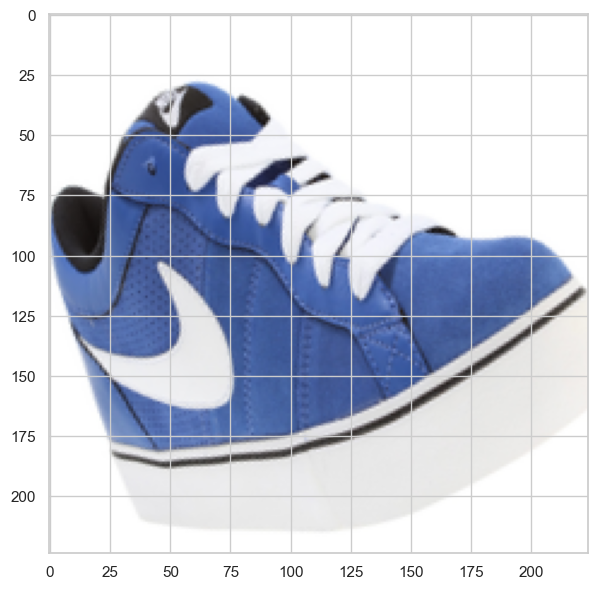

(10, 224, 224, 3)


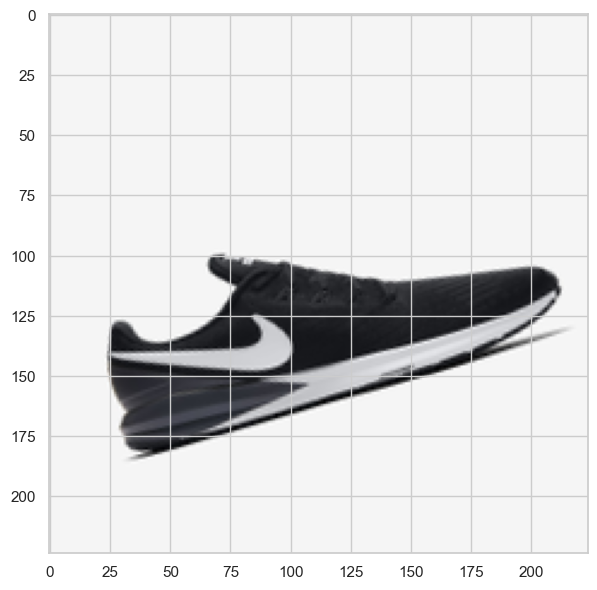

(150, 224, 224, 3)


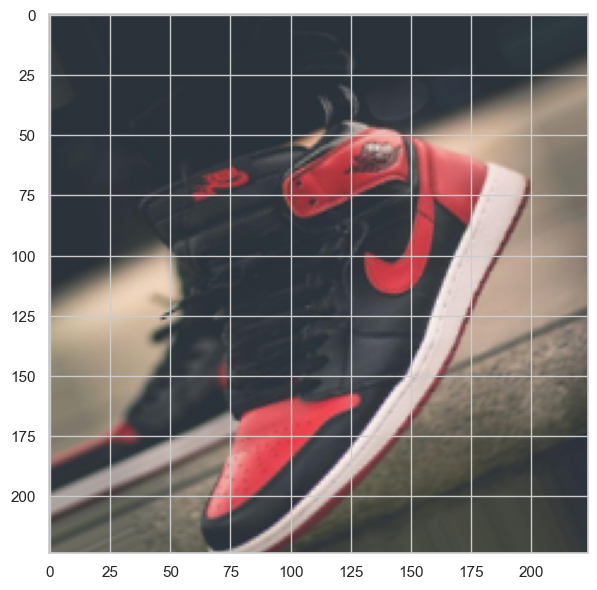

In [32]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

In [35]:
epoch =50
callback = EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      verbose=0,
      mode="auto",
      baseline=None,
      restore_best_weights=True,
    )

start = time.time()
history = dl_model.fit(train_generator,
    validation_data=validation_generator,
    epochs=epoch,
    verbose=2,
    callbacks=[callback])
end = time.time()

print("Model's Total Execution Time: ",end - start, " seconds")

Epoch 1/50


/Users/rahuldebmohalder/opt/anaconda3/lib/python3.8/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


4/4 - 38s - loss: 0.7569 - accuracy: 0.4978 - val_loss: 0.6949 - val_accuracy: 0.4909
Epoch 2/50
4/4 - 35s - loss: 0.6949 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.4909
Epoch 3/50
4/4 - 33s - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.4909
Epoch 4/50
4/4 - 36s - loss: 0.6932 - accuracy: 0.5043 - val_loss: 0.6953 - val_accuracy: 0.4909
Epoch 5/50
4/4 - 34s - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.6981 - val_accuracy: 0.4909
Epoch 6/50
4/4 - 32s - loss: 0.6947 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5091
Epoch 7/50
4/4 - 33s - loss: 0.6908 - accuracy: 0.6087 - val_loss: 0.6914 - val_accuracy: 0.5091
Epoch 8/50
4/4 - 33s - loss: 0.6908 - accuracy: 0.5065 - val_loss: 0.6892 - val_accuracy: 0.5091
Epoch 9/50
4/4 - 33s - loss: 0.6881 - accuracy: 0.5935 - val_loss: 0.6885 - val_accuracy: 0.5636
Epoch 10/50
4/4 - 34s - loss: 0.6820 - accuracy: 0.6109 - val_loss: 0.6820 - val_accuracy: 0.6000
Epoch 11/50
4/4 - 32s - loss: 0.6873 - a

# Summarize history for accuracy


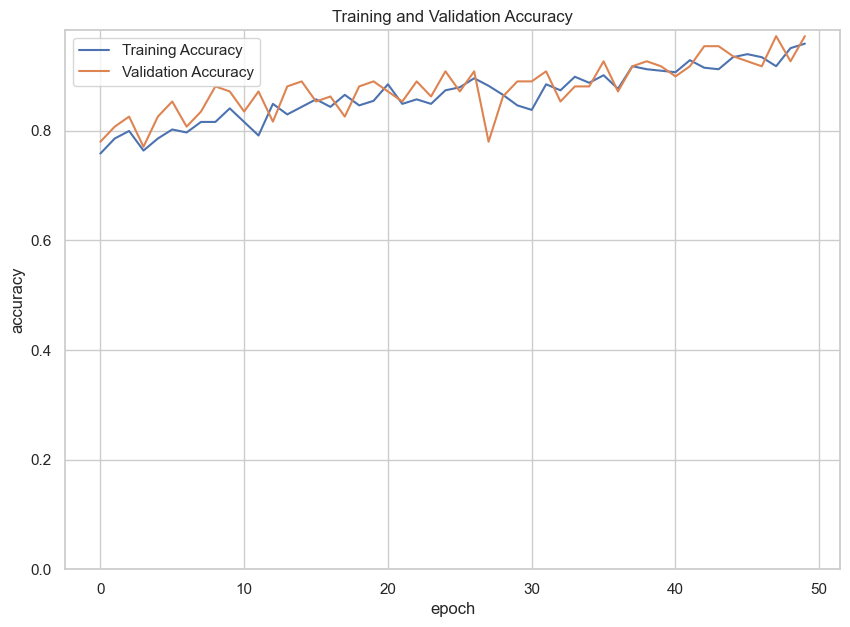

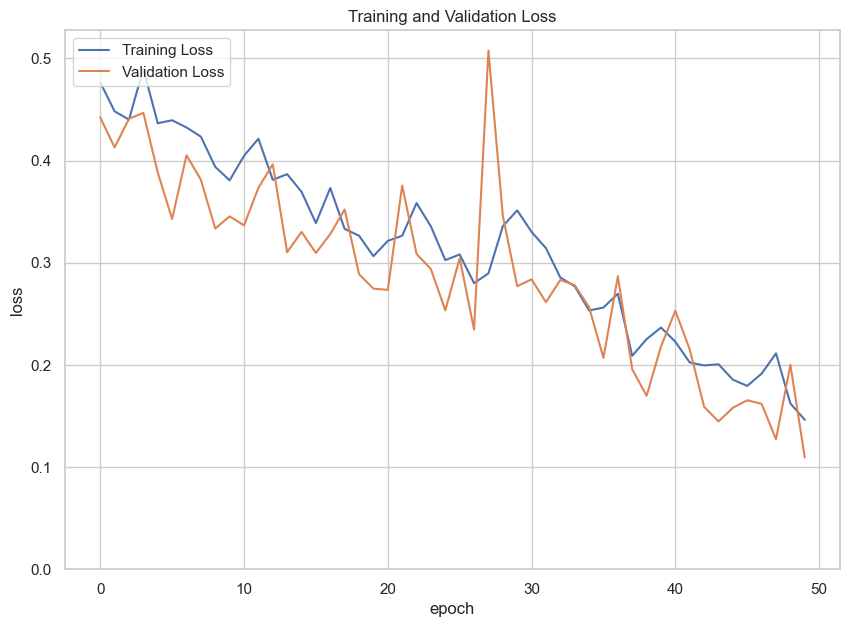

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0)
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0)
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

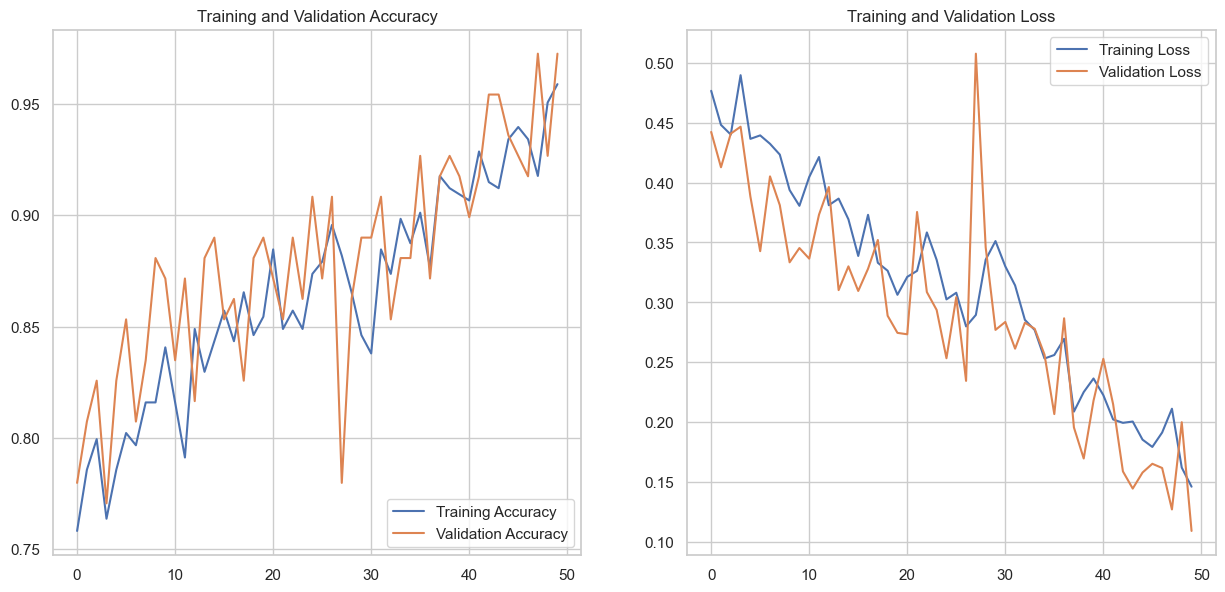

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
preds = dl_model.predict(test_generator)

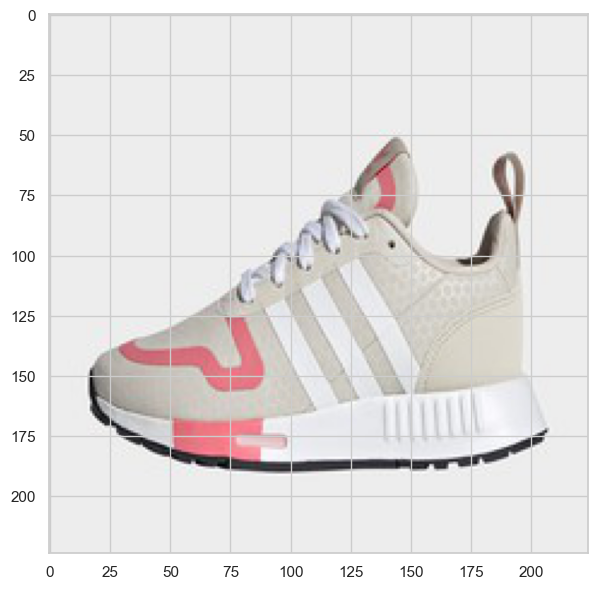

predicted class: Nike


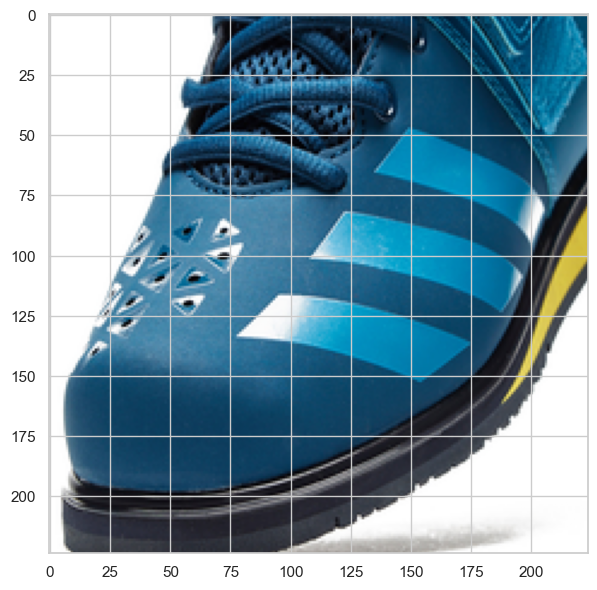

predicted class: Nike


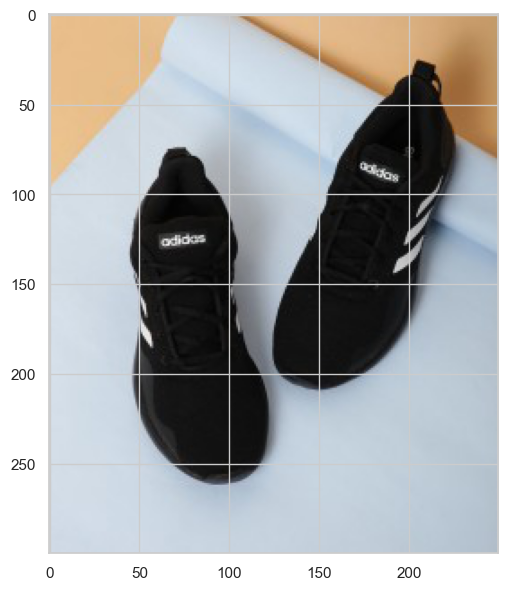

predicted class: Nike


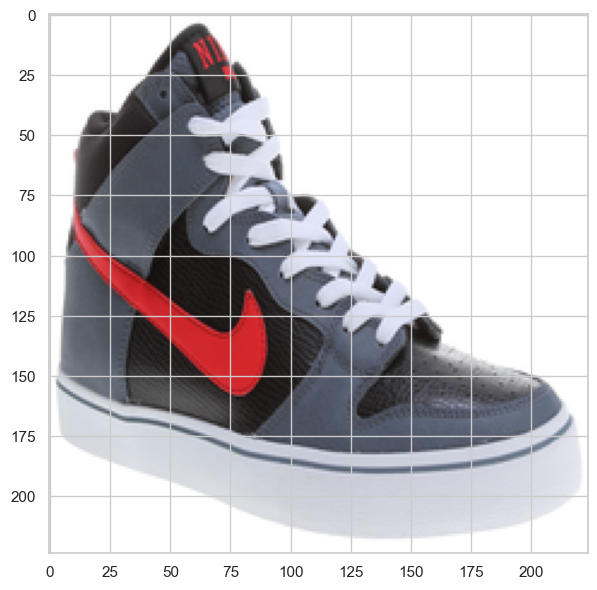

predicted class: Nike


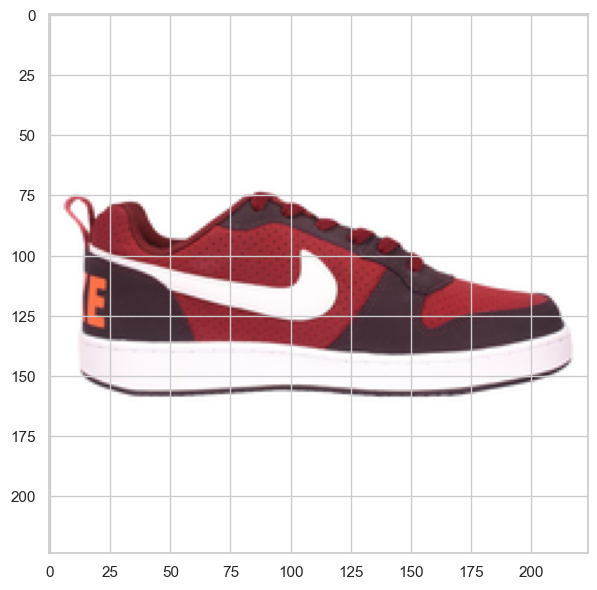

predicted class: Nike


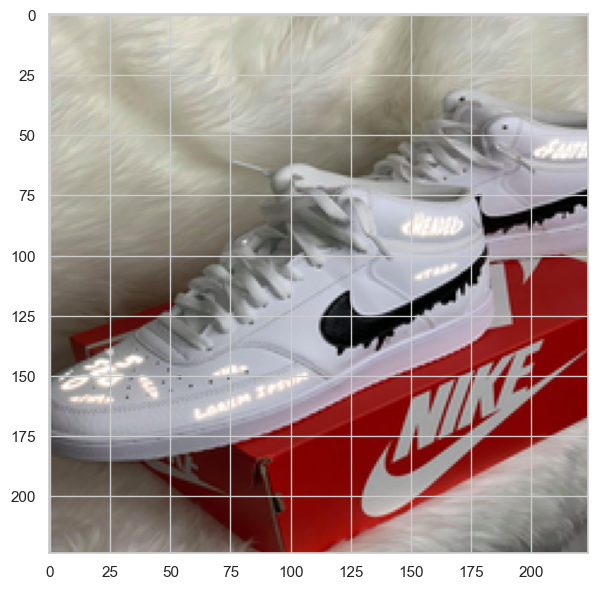

predicted class: Nike


IndexError: list index out of range

In [41]:
# Read image
def getPred(i):
    ex_img = mpimg.imread(test_generator.filepaths[i])
    plt.imshow(ex_img);
    plt.show();
    p = preds[i]
    if (p < 0.5).all():
        output = 'Adidas'
    else:
        output = 'Nike'
    print(f'predicted class: {output}')

for i in range(0, 150, 10):
    getPred(i)

In [43]:
print("Accurecy' and 'Loss'")
loss, acc = dl_model.evaluate(test_generator)
print('Accuracy: {:5.5f}%'.format(100 * acc))
print('Loss: {:5.5f}%', loss)

Accurecy' and 'Loss'
1/1 [==============================] - 2s 2s/step - loss: 0.7597 - accuracy: 0.5167
Accuracy: 51.66667%
Loss: {:5.5f}% 0.7597233653068542


#  Performance Measure (Confusion Matrix & ROC AUC Curves)


In [ ]:
Create a confusion matrix and plot the ROC AUC curve to show how the model performes.

In [45]:
import numpy as np
rounded_labels=np.argmax(preds, axis=1)
rounded_labels[1]

cm = confusion_matrix(rounded_labels, test_generator .classes)
cm

array([[ 5,  3],
       [25, 27]])

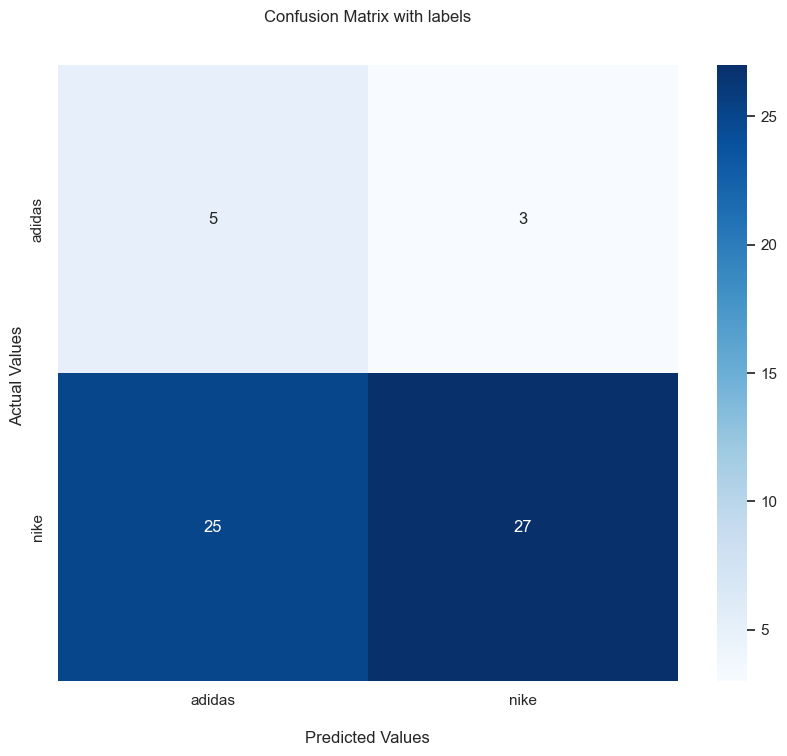

In [46]:
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt_fig 


fig, ax = plt_fig.subplots(figsize=(10, 8))

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['adidas','nike'])
ax.yaxis.set_ticklabels(['adidas','nike'])

## Display the visualization of the Confusion Matrix.
plt_fig.show()

In [47]:
preds=np.argmax(preds, axis=1)
preds[1]

fpr, tpr, _ = roc_curve(
    test_generator.classes, 
    preds   
)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [48]:
ras = roc_auc_score(test_generator.classes, preds)
print(f'The model\'s ROC_AUC score is: {ras:.2f}')

The model's ROC_AUC score is: 0.53


# Save the trained Deep Learning model


In [50]:
dl_model.save("adidas_nike_deep_learning_model.h5")

# Pre-Trained Model (Transfer Learning Model)

ResNet50V2 (It's a transfer learning  model)

In [2]:
def makeResNetModel():
    res_model = ResNet50V2(
        include_top=False, 
        input_shape=(224, 224, 3),
        classes=2
    )

    for layer in res_model.layers[:-1]:
        layer.trainable = False
    
    x = res_model.output
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="relu")(x)

    predictions = Dense(1, activation="sigmoid")(x)

    # creating the final model 
    model = Model(res_model.input, predictions)   
    return model

In [5]:
model_resnet50v2 = makeResNetModel()

In [6]:
model_resnet50v2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv4_block24_1_relu (Activatio (None, 14, 14, 256)  0           conv4_block24_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block24_2_pad (ZeroPaddin (None, 16, 16, 256)  0           conv4_block24_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block24_2_conv (Conv2D)   (None, 14, 14, 256)  589824      conv4_block24_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block24_2_bn (BatchNormal (None, 14, 14, 256)  1024        conv4_block24_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block24_2_relu (Activatio (None, 14, 14, 256)  0           conv4_block24_2_bn[0][0]         
__________

In [7]:
optimizer = Adam(learning_rate=1e-3)

model_resnet50v2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
epoch =50
callback = EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      verbose=0,
      mode="auto",
      baseline=None,
      restore_best_weights=True,
    )

start = time.time()
history_tf_res = model_resnet50v2.fit(train_generator,
    validation_data=validation_generator,
    epochs=epoch,
    verbose=2,
    callbacks=[])
end = time.time()

print("Model's Total Execution Time: ",end - start, " seconds")

Epoch 1/50
4/4 - 500s - loss: 0.7294 - accuracy: 0.8304 - val_loss: 0.6897 - val_accuracy: 0.8364
Epoch 2/50
4/4 - 425s - loss: 0.6412 - accuracy: 0.8543 - val_loss: 0.3555 - val_accuracy: 0.8727
Epoch 3/50
4/4 - 279s - loss: 0.4623 - accuracy: 0.8826 - val_loss: 0.6050 - val_accuracy: 0.8364
Epoch 4/50
4/4 - 277s - loss: 0.4491 - accuracy: 0.8848 - val_loss: 0.3085 - val_accuracy: 0.8727
Epoch 5/50
4/4 - 2096s - loss: 0.3061 - accuracy: 0.9109 - val_loss: 0.4717 - val_accuracy: 0.8364
Epoch 6/50
4/4 - 280s - loss: 0.2781 - accuracy: 0.9065 - val_loss: 0.5272 - val_accuracy: 0.8364
Epoch 7/50
4/4 - 277s - loss: 0.2099 - accuracy: 0.9196 - val_loss: 0.5223 - val_accuracy: 0.8000
Epoch 8/50
4/4 - 2075s - loss: 0.2067 - accuracy: 0.9304 - val_loss: 0.2989 - val_accuracy: 0.8909
Epoch 9/50
4/4 - 285s - loss: 0.2982 - accuracy: 0.9152 - val_loss: 0.4014 - val_accuracy: 0.8000
Epoch 10/50
4/4 - 27478s - loss: 0.2418 - accuracy: 0.9196 - val_loss: 0.7841 - val_accuracy: 0.8182
Epoch 11/50
4/4

# Summarize history for accuracy

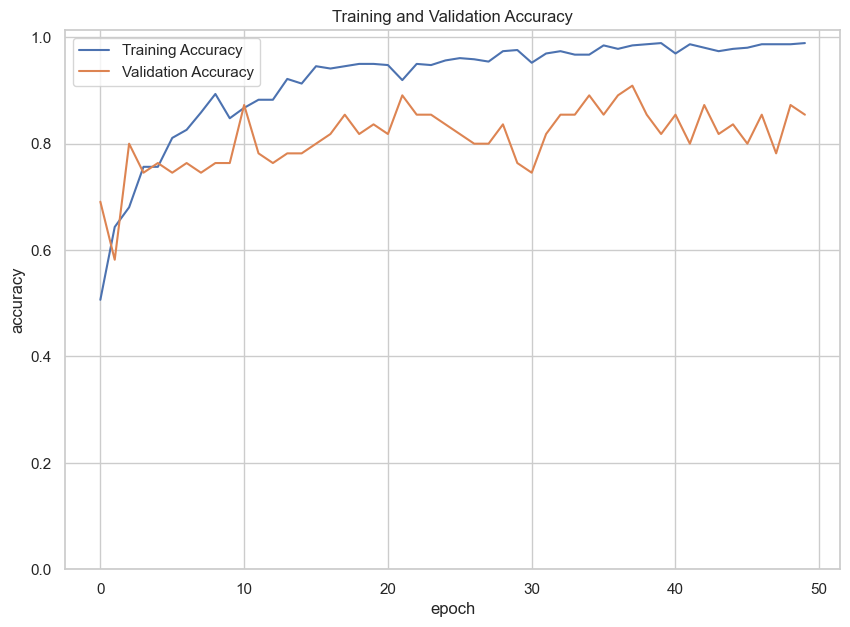

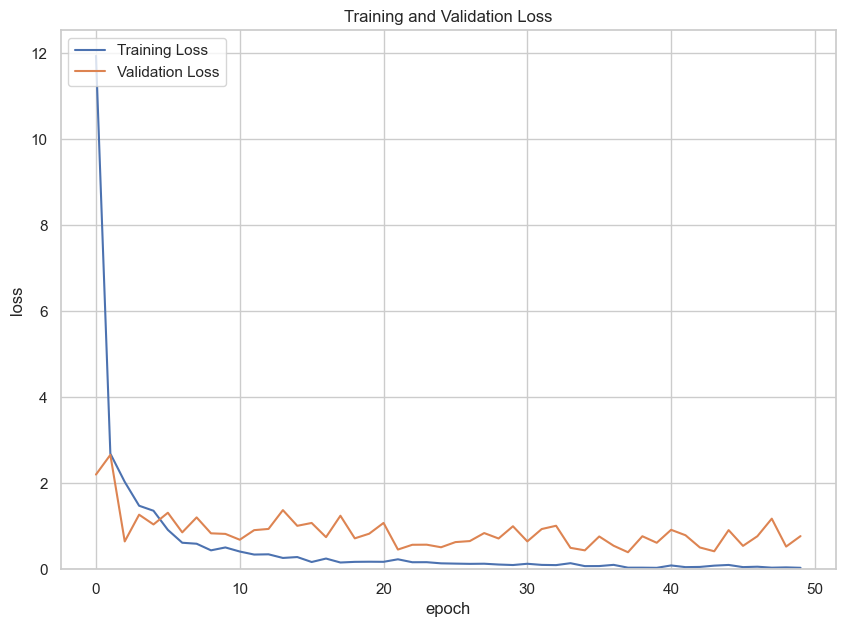

In [61]:
plt.plot(history_tf_res.history['accuracy'])
plt.plot(history_tf_res.history['val_accuracy'])
plt.ylim(0)
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_tf_res.history['loss'])
plt.plot(history_tf_res.history['val_loss'])
plt.ylim(0)
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


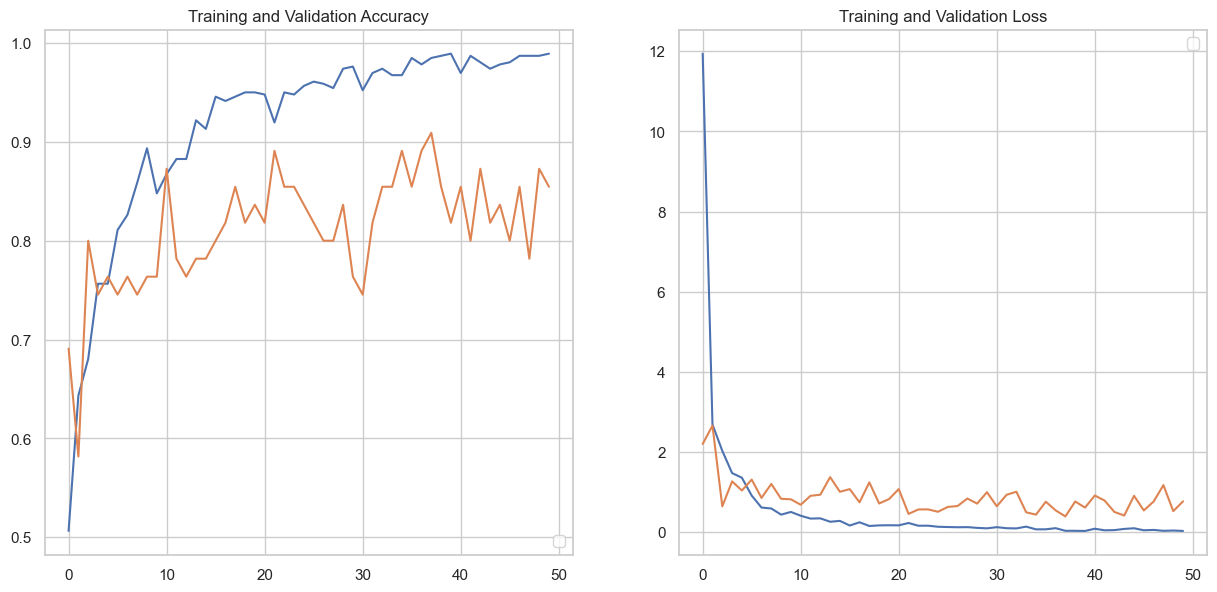

In [62]:
acc = history_tf_res.history['accuracy']
val_acc = history_tf_res.history['val_accuracy']
loss = history_tf_res.history['loss']
val_loss = history_tf_res.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(history_tf_res.history['accuracy'])
plt.plot(history_tf_res.history['val_accuracy'])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_tf_res.history['loss'])
plt.plot(history_tf_res.history['val_loss'])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
preds = model_resnet50v2.predict(test_generator)

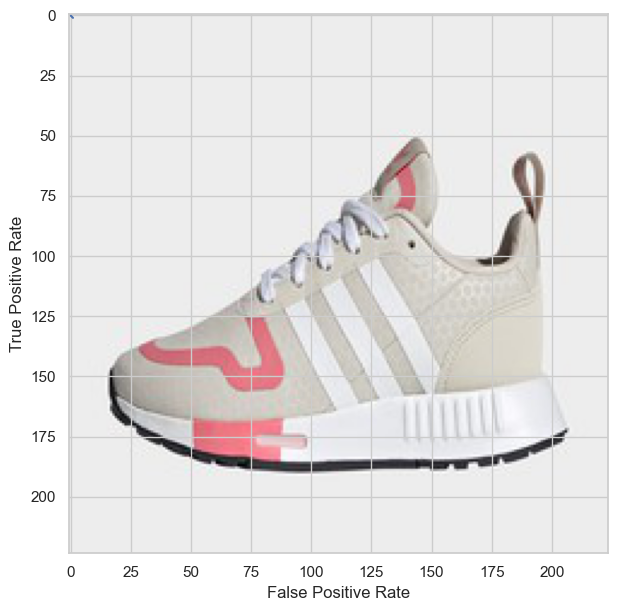

predicted class: Adidas


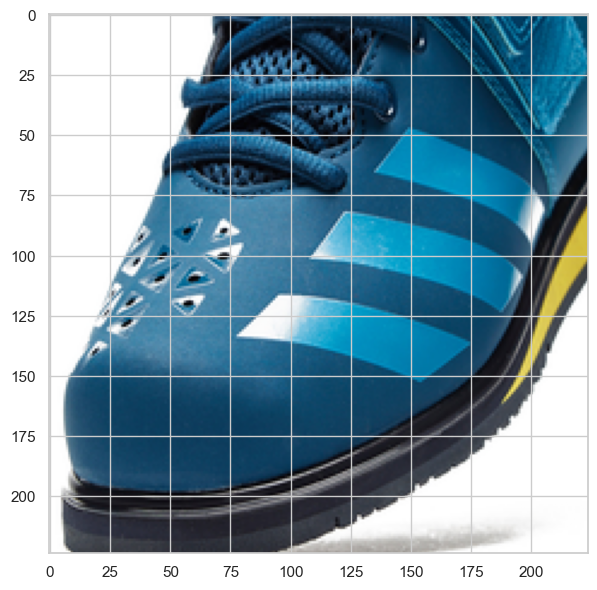

predicted class: Adidas


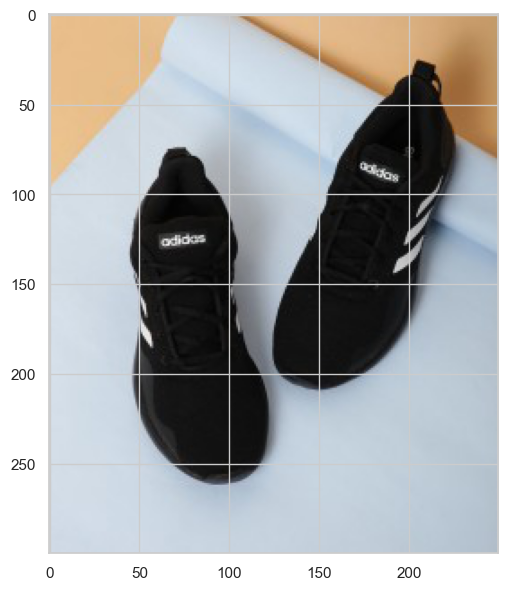

predicted class: Adidas


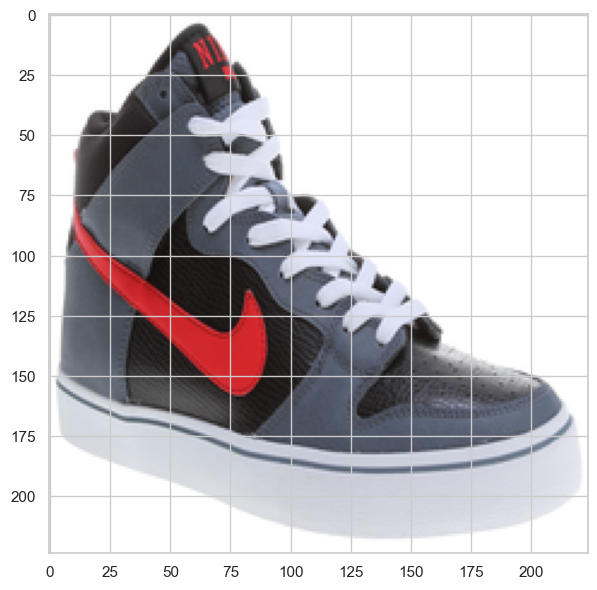

predicted class: Adidas


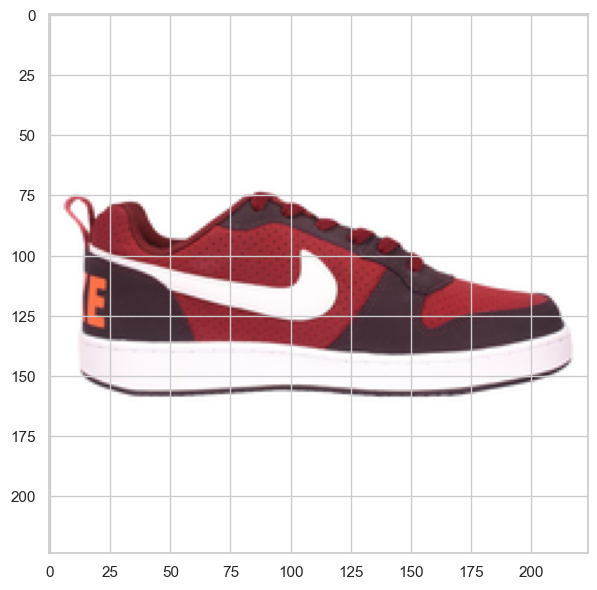

predicted class: Adidas


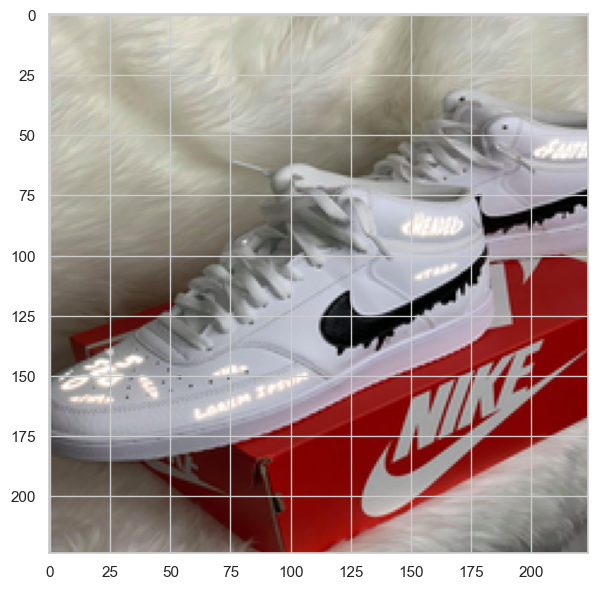

predicted class: Adidas


IndexError: list index out of range

In [37]:
# Read image
def getPred(i):
    ex_img = mpimg.imread(test_generator.filepaths[i])
    plt.imshow(ex_img);
    plt.show();
    p = preds[i]
    if (p < 0.5).all():
        output = 'Adidas'
    else:
        output = 'Nike'
    print(f'predicted class: {output}')

for i in range(0, 100, 10):
    getPred(i)

In [32]:
print("Accurecy' and 'Loss'")
loss, acc = model_resnet50v2.evaluate(test_generator)
print('Accuracy: {:5.5f}%'.format(100 * acc))
print('Loss: {:5.5f}%', loss)

Accurecy' and 'Loss'
1/1 [==============================] - 40s 40s/step - loss: 0.6583 - accuracy: 0.8667
Accuracy: 86.66667%
Loss: {:5.5f}% 0.6583265066146851


#  Performance Measure (Confusion Matrix & ROC AUC Curves)

In [33]:
import numpy as np
rounded_labels=np.argmax(preds, axis=1)
rounded_labels[1]

# predictions = np.where(preds >= 0.5, 1, 0)
cm_tf_res = confusion_matrix(rounded_labels, test_generator .classes)
cm_tf_res

array([[30, 30],
       [ 0,  0]])

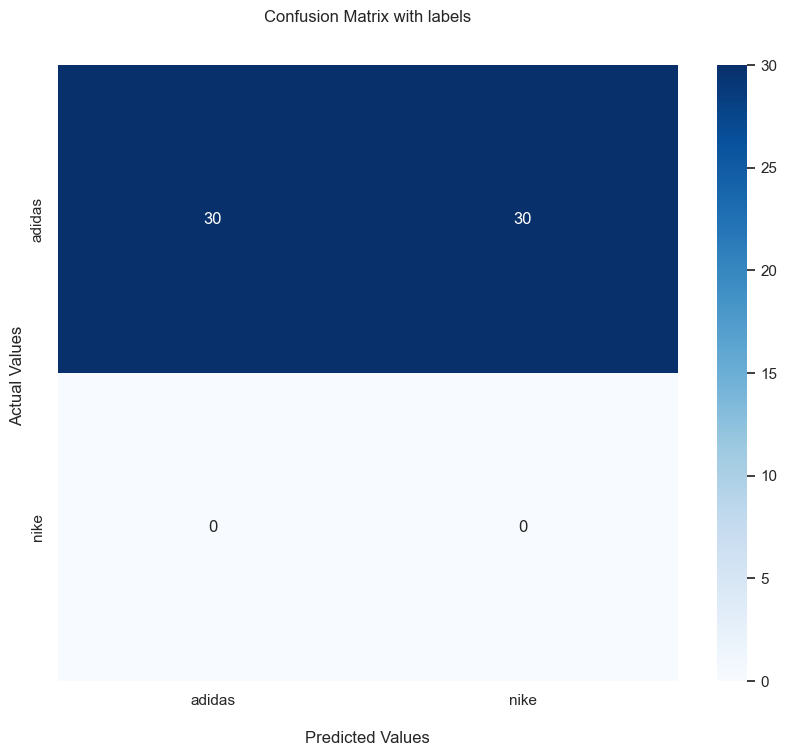

In [34]:
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt_fig 


fig, ax = plt_fig.subplots(figsize=(10, 8))

ax = sns.heatmap(cm_tf_res, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['adidas','nike'])
ax.yaxis.set_ticklabels(['adidas','nike'])

## Display the visualization of the Confusion Matrix.
plt_fig.show()

In [35]:
preds=np.argmax(preds, axis=1)
preds[1]

fpr, tpr, _ = roc_curve(
    test_generator.classes, 
    preds   
)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [36]:
ras = roc_auc_score(test_generator.classes, preds)
print(f'The model\'s ROC_AUC score is: {ras:.2f}')

The model's ROC_AUC score is: 0.50


# Save the model


In [40]:
model_resnet50v2.save("adidas_nike_transfer_learning_resnet50v2_model.h5")

# Requirements File Generate

In [38]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Additional Techniques

To enhance the performance of the models (deep learning model and pre-trained model) first we need to apply some data optimization techniques to optimize the data. Then need to apply some algorithm-tuning techniques to tune the deep CNN model or to add some new features or layers in the pre-trained model. We can use some hyperparameters optimization processes and some ensemble methods to enhance the performance. So those techniques are-
(a) Data optimization
(b) Algorithm tuning
(c) Hyperparameters optimization
(d) Ensemble methods